# Generic Approach for Explaining Drifts in Business Processes using Process Mining - Implementation for One Dataset
*Author: Lennart Ebert (mail@lennart-ebert.de)*
</br></br>

This notebook detects primary and related secondary driftpoints according to the approach developed in the Master's thesis "A Generic Approach for Explaining Drifts in Business Processes using Process Mining".

The user specifies a file path for the dataset to analyze and configures the primary as well as secondary drift detectors.

Outputs are graphs as well as drift point lists.

## Setup
### Imports

In [1]:
## imports

# general imports
import math
import pandas as pd
import cProfile
import pstats
import pathlib
from pm4py.objects.log.importer.xes import importer as xes_importer

# module with helper functions
import helper

# modules of the developed approach
from processdrift.explanation import drift_detection
from processdrift.explanation import drift_explanation
from processdrift.explanation import feature_extraction
from processdrift.explanation import population_comparison
from processdrift.explanation import windowing
from processdrift.explanation import change_point_extraction

### Data settings and event log loading

In [2]:
# data settings
data_file_path = 'data/synthetic/generated_datasets/sudden_3_attribute_values/10000/cf10k_0bbd4c9b-97ca-4594-ad55-32d3686e7756.xes' # + 'data\\synthetic\\maardji et al 2013_xes_attributes\\logs\\cb\\cb2.5k.xes' # 

# load event log
event_log = xes_importer.apply(data_file_path)

c:\Users\Lennart\Tools\Anaconda3\envs\concept_drift_test\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 10000/10000 [00:09<00:00, 1016.96it/s]


### Configure Primary Drift Detector

The user can choose which primary drift detector to use and how to configure it. 

There are three different primary drift detector options:
1. ProDrift Drift Detector: Uses the Apromore ProDrift drift detector, a third party implementation.
2. A custom hypothesis test based drift detector: The user configures a hypothesis test based drift detector by choosing from pre-implemented components and setting their parameters.
3. Change Points Known: The user specifies the change points manually so that only the secondary perspective detection is performed.

To use each alternative, the according block of code needs to be (un-)commented.

In [3]:
# alternative 1: use the ProDrift Drift detector
# primary_process_drift_detector = drift_detection.ProDriftDD(path_to_prodrift='ProDrift2.5/ProDrift2.5.jar',
#                                                                         drift_detection_mechanism='runs',
#                                                                         window_size=200,
#                                                                         window_mode='adaptive',
#                                                                         detect_gradual_as_well=False)

In [4]:
# alternative 2: Configure custom drift detector
# the user can select 
# - a primary feature extractor, specifying which primary axis feature to use
# - a window generator (fixed size or adaptive) incl. the window sizes and further settings
# - a population comparer
# - a threshold for detecting the change points

primary_window_size = 200
primary_slide_by = 10
primary_feature_extractor = feature_extraction.RunsFE()
primary_window_generator = windowing.FixedWG(window_size=primary_window_size, slide_by=primary_slide_by)
primary_population_comparer = population_comparison.GTestPC(0)

primary_threshold = 0.05
primary_proportional_phi = 0.5

primary_phi = math.ceil(primary_window_size / primary_slide_by * primary_proportional_phi)
primary_rho = 3
print(f"primary_phi={primary_phi}, primary_rho={primary_rho}")

primary_change_point_extractor = change_point_extraction.PhiFilterCPE(primary_threshold, primary_phi, primary_rho)

primary_process_drift_detector = drift_detection.HypothesisTestDD(primary_feature_extractor, 
                                                               primary_window_generator,
                                                               primary_population_comparer, 
                                                               change_point_extractor=primary_change_point_extractor)

primary_phi=10, primary_rho=3


In [5]:
# alternative 3: Change points known

# provide a list of change points
known_change_point = helper.get_change_points_maardji_et_al_2013(len(event_log))

primary_process_drift_detector = drift_detection.TrueKnownDD(known_change_point)

### Configure Secondary Drift Detectors

The user can specify a list of secondary drift detectors.

For attribute drift detection, the method `get_attribute_drift_detectors` from the `drift_detection` module can be used to create drift detectors for all specified attributes.

In [6]:
secondary_window_size = 200
secondary_slide_by = 10
secondary_window_generator = windowing.FixedWG(secondary_window_size, slide_by=secondary_slide_by)
secondary_threshold = 0.05
secondary_max_distance = 300

secondary_phi = math.ceil(secondary_window_size / secondary_slide_by / 2)
secondary_rho = 1
print(f"secondary_phi={secondary_phi}, secondary_rho={secondary_rho}")

secondary_change_point_extractor = change_point_extraction.PhiFilterCPE(secondary_threshold, secondary_phi, secondary_rho)

attribute_level_types = helper.get_attributes_and_types_for_synthetic_data()

secondary_drift_detectors = drift_detection.get_attribute_drift_detectors(attribute_level_types,
                                                                         secondary_window_generator, 
                                                                         change_point_extractor=secondary_change_point_extractor)

secondary_phi=10, secondary_rho=1


## Run the Change Point Explainer

In [7]:
# create the change point explainer
drift_explainer = drift_explanation.DriftExplainer(primary_process_drift_detector, secondary_drift_detectors)

# get the change point explanations
possible_drift_explanations = drift_explainer.get_possible_drift_explanations(event_log, max_distance=secondary_max_distance)

In [8]:
# show the possible change point explanations
possible_drift_explanations.to_table()

,Primary Change Point,Detector,Secondary Change Point,Lag
0,1000,trace: relevant_attribute_01,1020,20
1,2000,trace: relevant_attribute_02,2030,30
2,3000,trace: relevant_attribute_03,3060,60
3,4000,trace: relevant_attribute_04,4020,20
4,4000,trace: relevant_attribute_03,3970,-30
5,4000,trace: irrelevant_attribute_04,3740,-260
6,5000,trace: relevant_attribute_05,5030,30
7,8000,trace: irrelevant_attribute_02,8060,60
8,8000,trace: irrelevant_attribute_02,7820,-180
9,9000,trace: irrelevant_attribute_01,9190,190


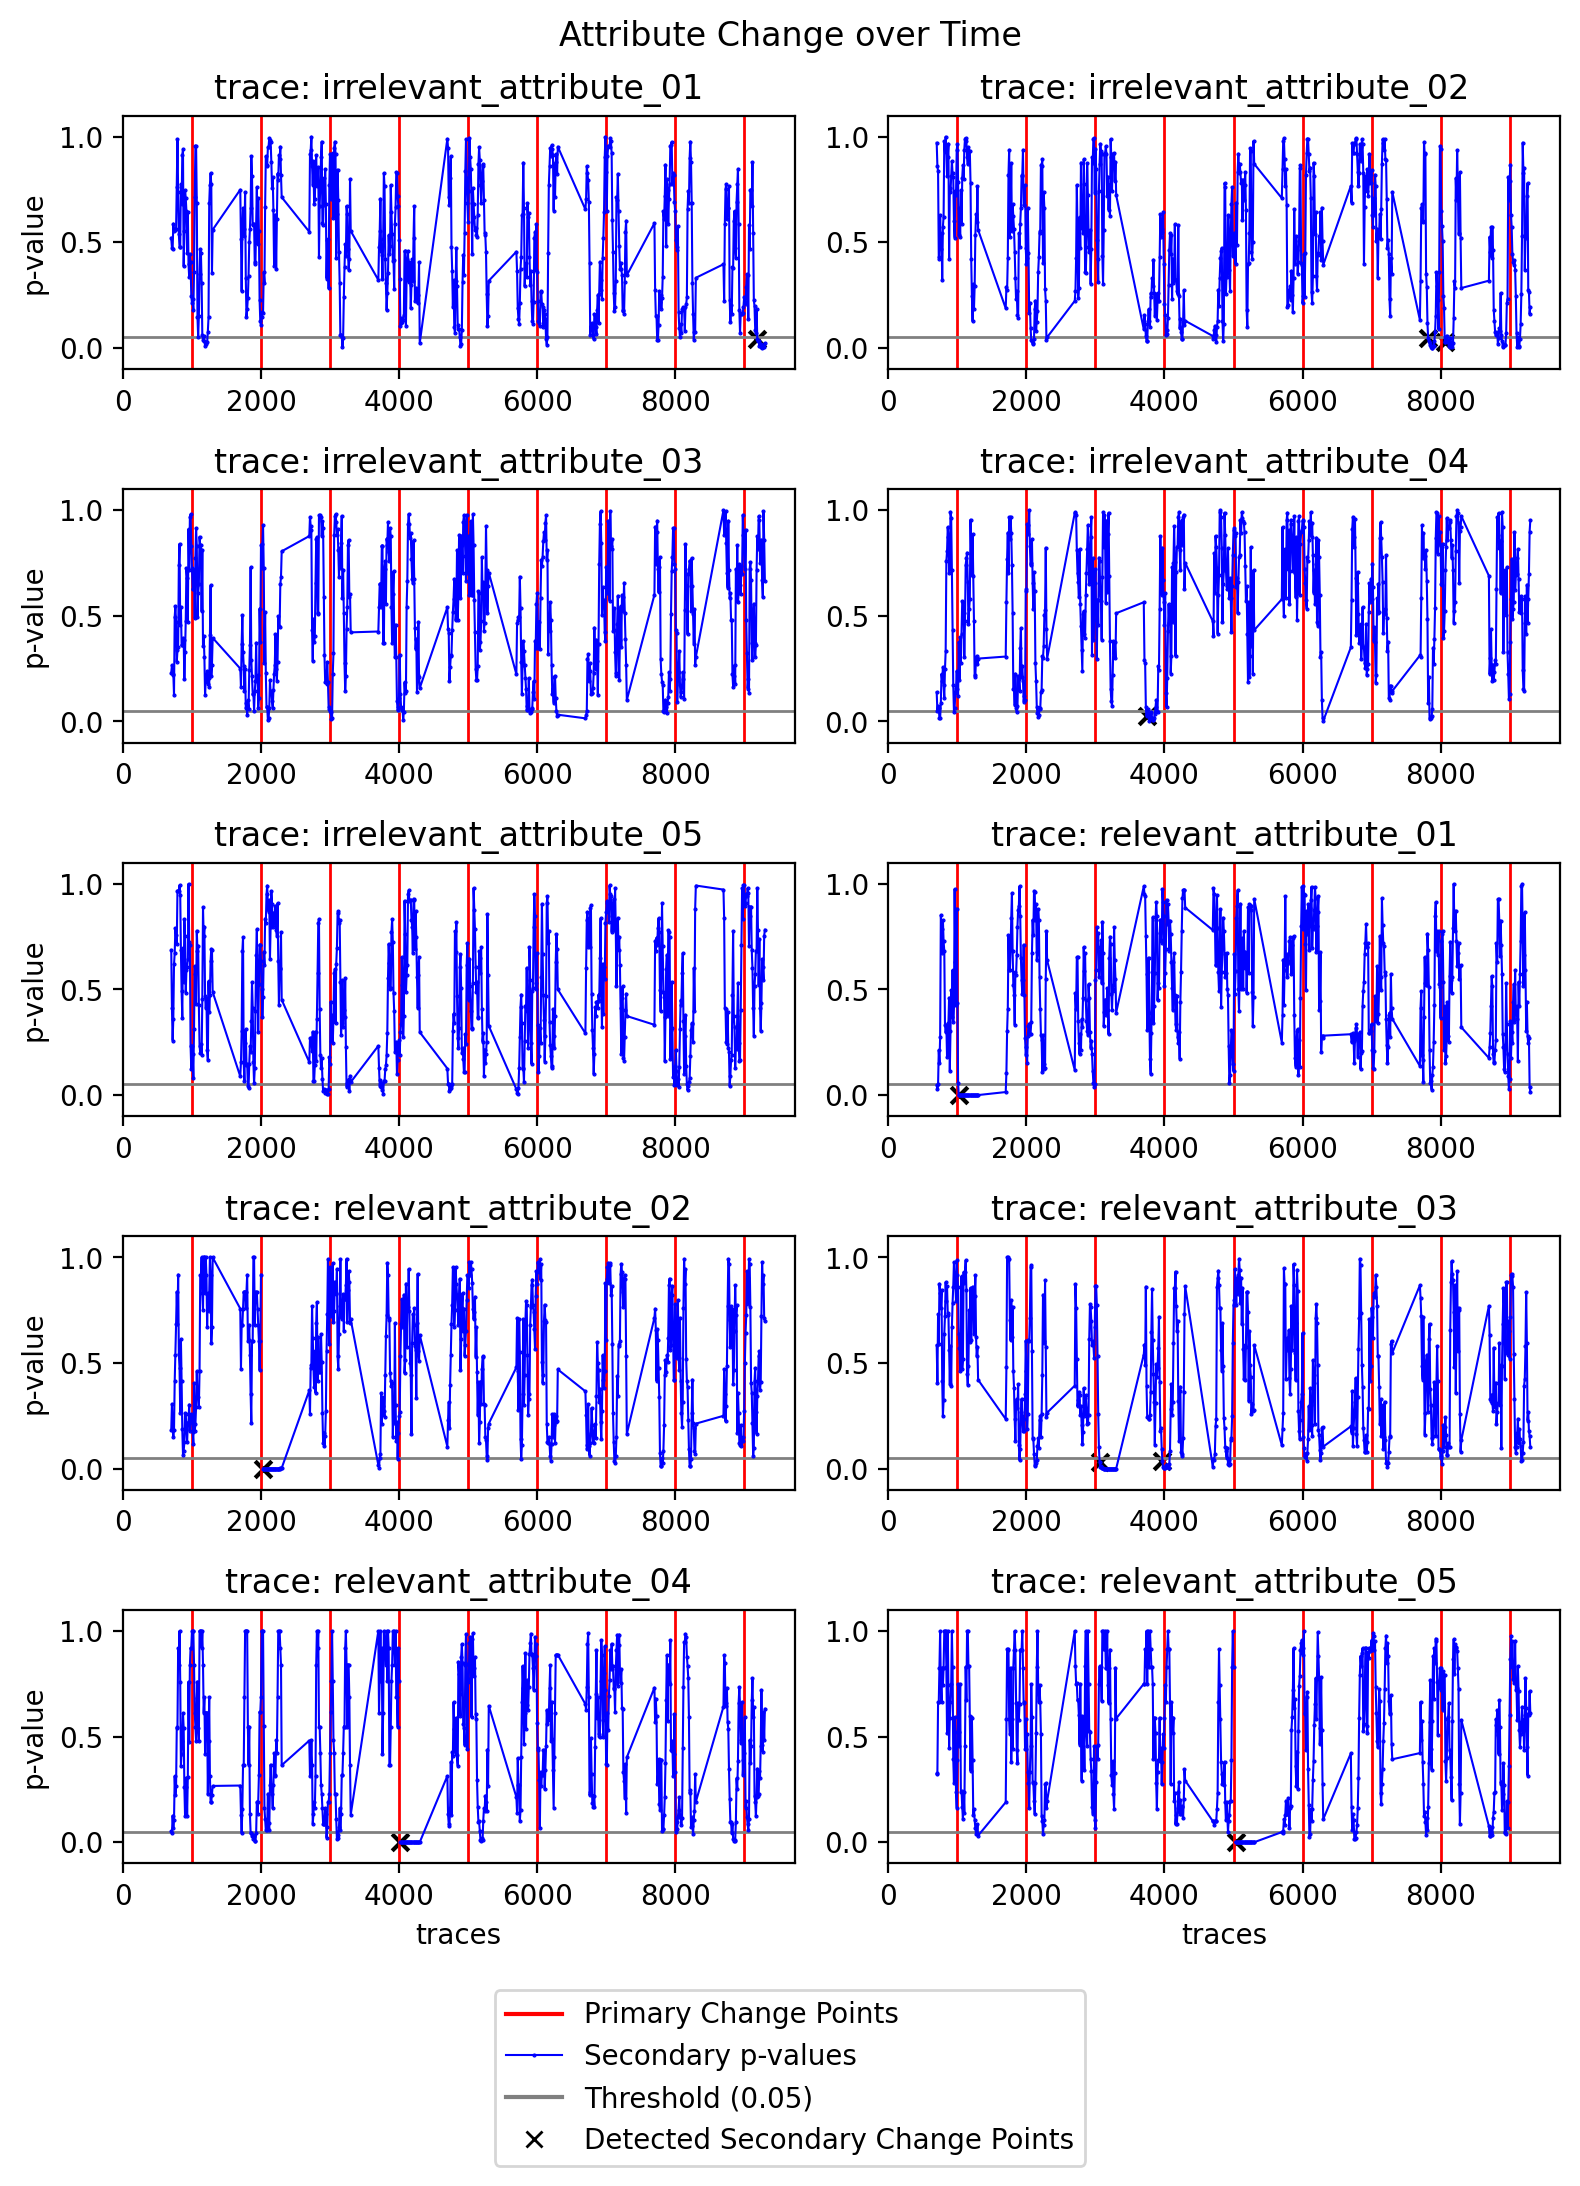

In [9]:
possible_drift_explanations.plot(offset_legend=-0.1)
pass

## Perform Runtime Analysis

In [10]:
# create the output folder
pathlib.Path("results/runtime/").mkdir(parents=True, exist_ok=True)

# run cProfile
cProfile.run('drift_explainer.get_possible_drift_explanations(event_log, max_distance=secondary_max_distance)', 'results/runtime/profile.stats')

# show cProfile results
p = pstats.Stats("results/runtime/profile.stats")
p.sort_stats(pstats.SortKey.CUMULATIVE)
p.print_stats()

Thu Aug 25 21:25:22 2022    results/runtime/profile.stats

         8722156 function calls (8699906 primitive calls) in 8.160 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    8.160    8.160 {built-in method builtins.exec}
        1    0.000    0.000    8.160    8.160 <string>:1(<module>)
        1    0.000    0.000    8.160    8.160 c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\explanation\drift_explanation.py:25(get_possible_drift_explanations)
       10    0.000    0.000    8.160    0.816 c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\explanation\drift_detection.py:66(get_changes)
       10    0.066    0.007    8.152    0.815 c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\explanation\drift_detection.py:98(_get_change_series)
     5490    0.060    0.000    4.265    0.001 c:\Users\Lennart\Documents\1

'gprof2dot' is not recognized as an internal or external command,
operable program or batch file.


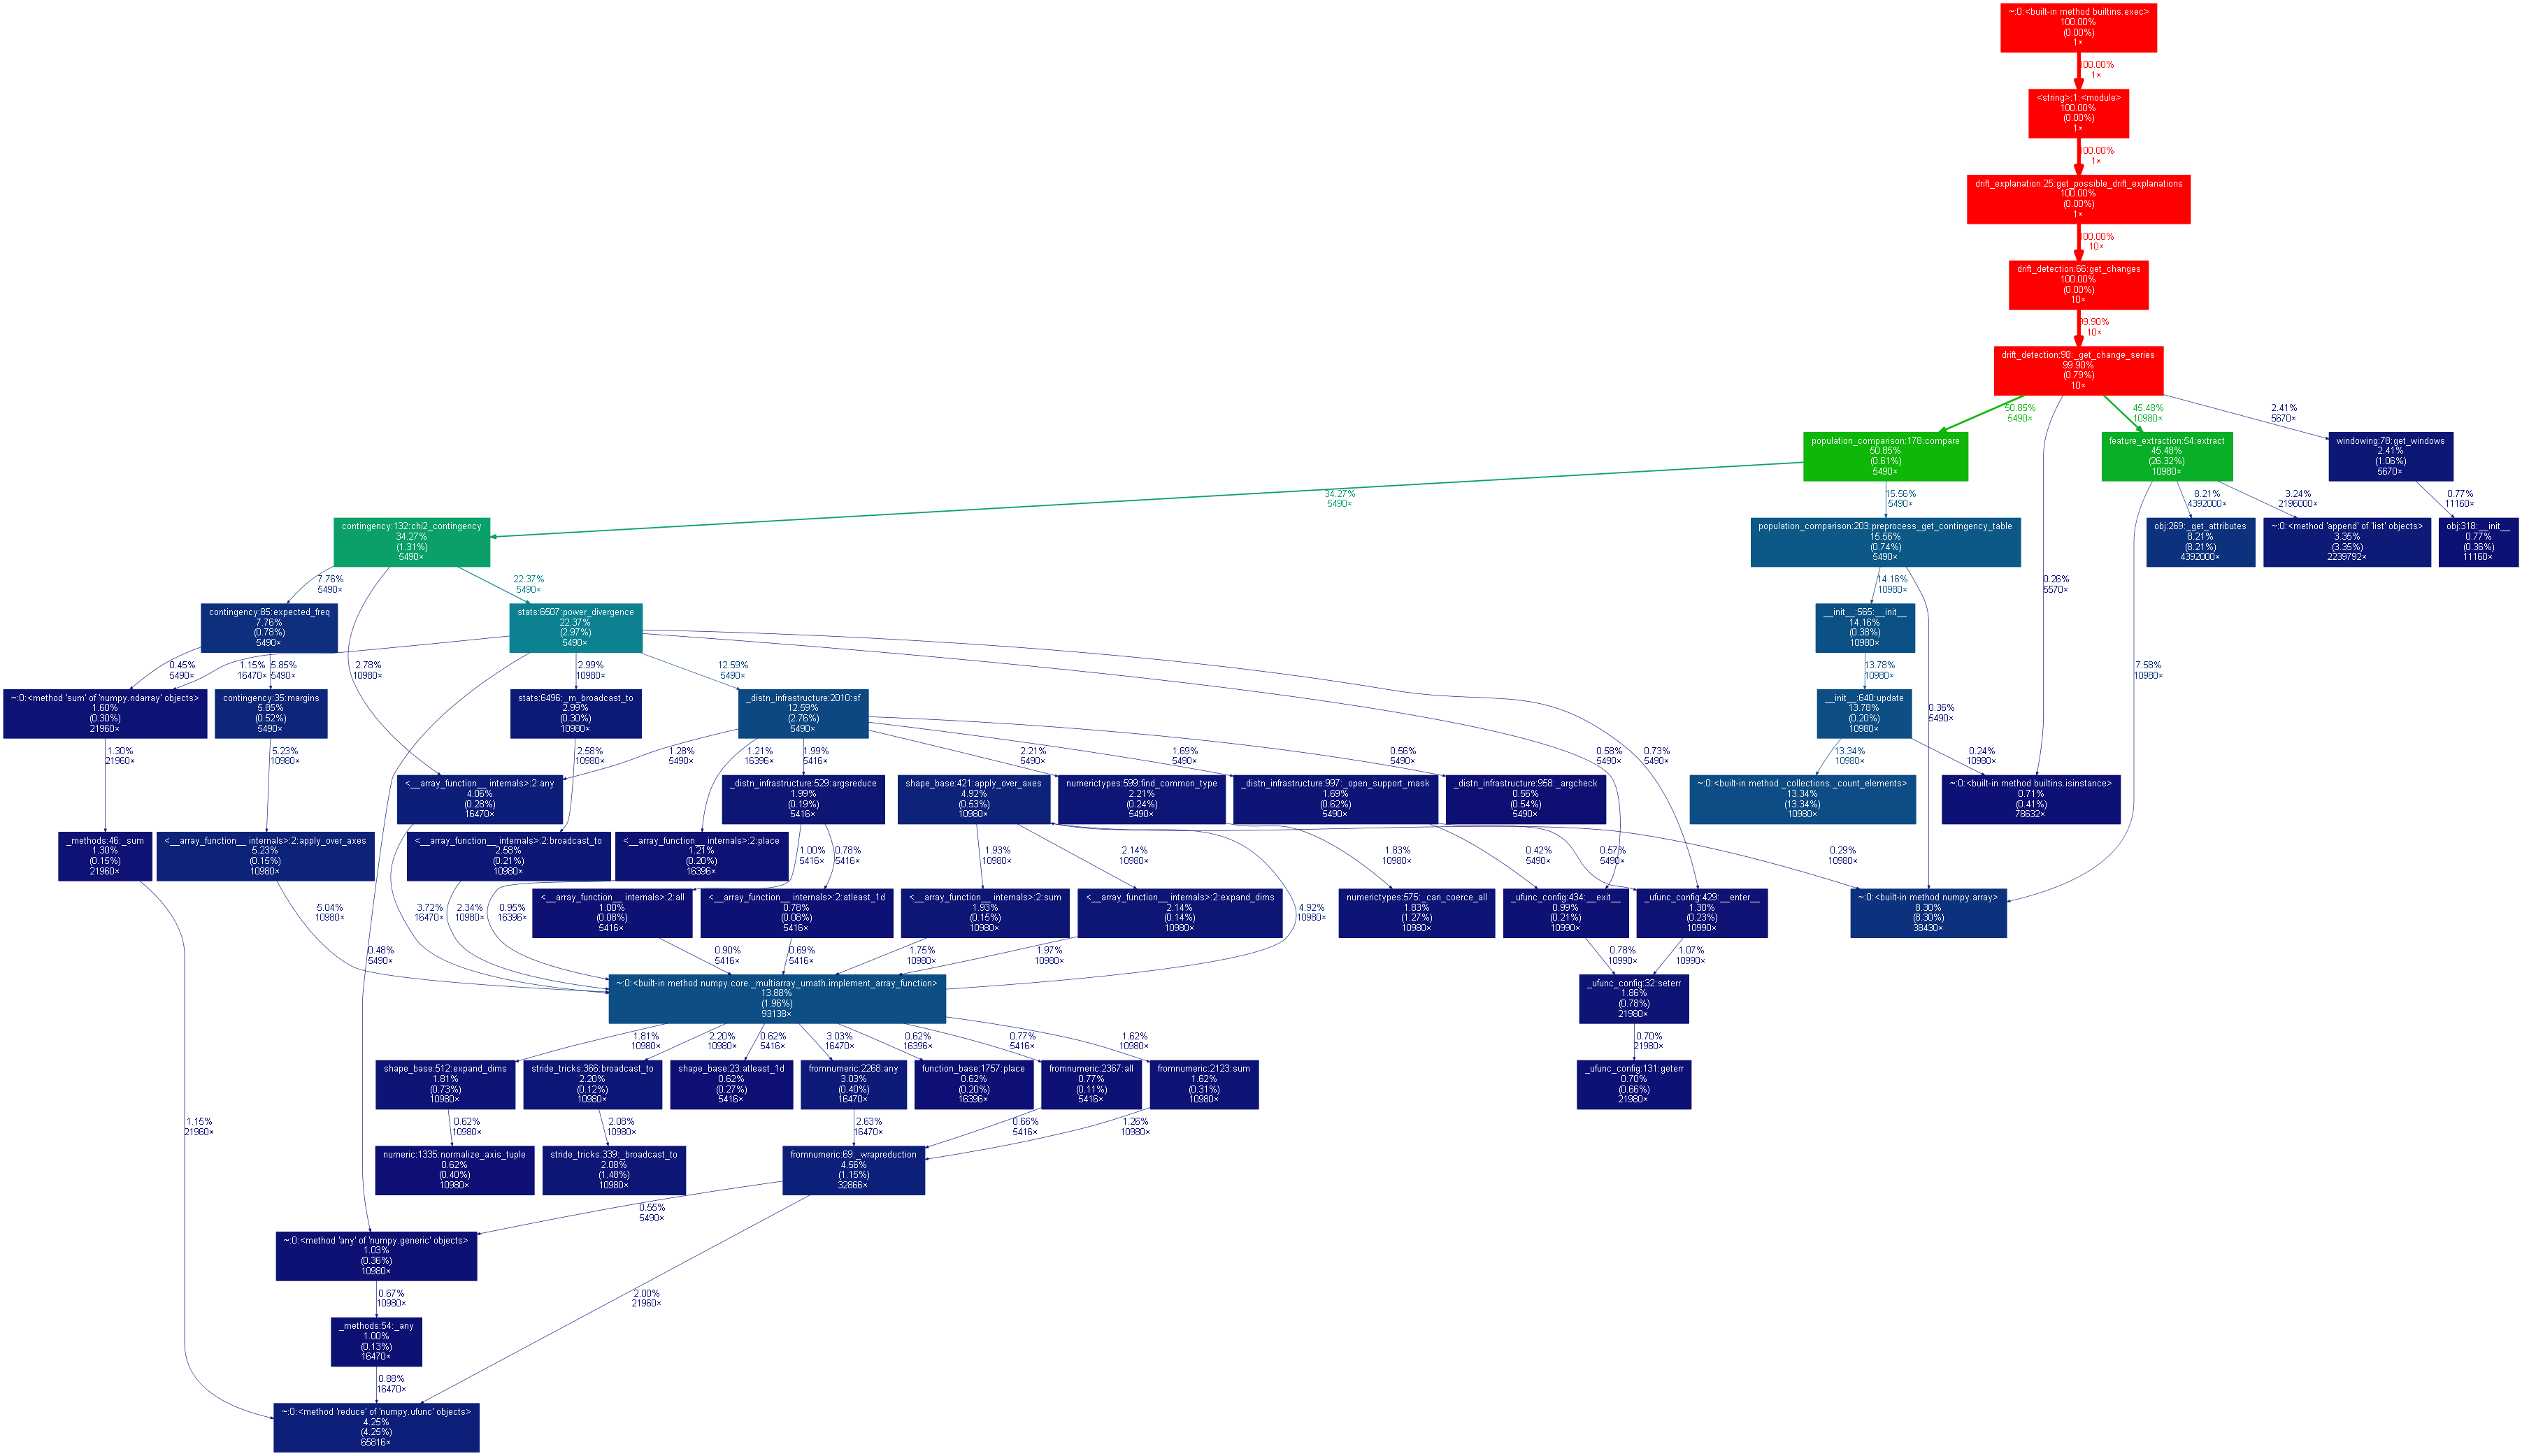

In [11]:
# show cProfile results as graph
!gprof2dot "results/runtime/profile.stats" -f pstats | dot -Tpng -o "results/runtime/output.png"

from IPython.display import Image
Image(filename='results/runtime/output.png') 